# Case 3: Recheio Customer Data Enrichment & Recommendation Engine

This case study focuses on enriching Recheio Cash & Carry’s customer dataset to deliver more relevant product recommendations across digital channels such as the website, mobile app, POS, and contact center. The project combines customer segmentation and association rule mining to develop systems like **Smart Baskets** and **Did You Forget**, enhancing customer experience and increasing Recheio’s share in total customer purchases.

## Business Problem
- Recheio serves two distinct segments (HoReCa and Traditional Retail), each with unique needs.  
- Customer relationship and loyalty are heavily dependent on personalized and insightful interactions.  
- Current data systems are fragmented, limiting the ability to generate impactful recommendations.  
- There is a need to increase **Recheio’s share of wallet** by becoming more relevant in each customer’s purchasing behavior.

---

**This notebook was developed by:**  
- João Venichand - 20211644  
- Gonçalo Custódio - 20211643  
- Diogo Correia - 20211586  
- Duarte Emanuel - 20240564

# **1. Import Libraries**

In [1]:
import warnings
import pandas as pd
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
from collections import defaultdict
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from scipy.sparse import csr_matrix
from tabulate import tabulate
from IPython.display import display

from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

# **2. Datasets**

In [2]:
data = pd.read_excel('data_with_clusters.xlsx')
data

c:\Users\gonca\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
c:\Users\gonca\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


,Date,Client ID,ID Product,YearMonth,ZIP Code,ID Client Type,Product Description,ID Product Category,Cluster
0,2022-01-02,210100281,224780,2022-01,4400,Café/Pastelaria,FARINHA ESPIGA AMIDO MILHO LUS.2KG,FARINHAS,2
1,2022-01-02,210100281,276806,2022-01,4400,Café/Pastelaria,LARANJA CAL7 (67/76) RCH,FRUTAS FRESCAS,2
2,2022-01-02,210100281,276809,2022-01,4400,Café/Pastelaria,LIMAO CAL 3/4 RCH,FRUTAS FRESCAS,2
3,2022-01-02,210100281,277674,2022-01,4400,Café/Pastelaria,COGUMELO BRANCO MÉDIO RCH,LEGUMES FRESCOS,2
4,2022-01-02,210100281,277917,2022-01,4400,Café/Pastelaria,TOMATE BB 67/82 1CAM RCH,LEGUMES FRESCOS,2
...,...,...,...,...,...,...,...,...,...
884094,2022-12-31,210106386,949447,2022-12,4000,Hotelaria,"BATATA WEDGES C PELE ECOFROST CG 2,5 KG",BATATA,0
884095,2022-12-31,210106386,954062,2022-12,4000,Hotelaria,FIAMBRE FATIADO CASA PORTUGUESA 750G,FIAMBRES,0
884096,2022-12-31,210199916,106702,2022-12,4480,NaN,MOSTARDA DONA SARAH 950GR,MOLHOS,4
884097,2022-12-31,210199916,906800,2022-12,4480,NaN,MOLHO INGLES UNCLE THOMAS 1 LT,MOLHOS,4


In [3]:
data.columns

Index(['Date', 'Client ID', 'ID Product', 'YearMonth', 'ZIP Code',
       'ID Client Type', 'Product Description', 'ID Product Category',
       'Cluster'],
      dtype='object')

In [4]:
horeca = pd.read_excel('horeca_data.xlsx')
horeca

c:\Users\gonca\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
c:\Users\gonca\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


,Date,Client ID,ID Product,YearMonth,ZIP Code,ID Client Type,Product Description,ID Product Category,Recency,Frequency,...,Sunday,YearWeek,Avg_Products_Per_Week,Avg_Products_Per_Purchase,Region,Region_Centro,Region_Lisboa,Region_Norte,Region_Porto,Region_Sul
0,2022-01-02,210105700,941436,2022-01,4400,NaN,* LOMBO DE PORCO C AMEIXAS INOX,PRATO DE CARNE,16,36,...,0.321918,2022-01,7.300000,4.055556,Porto,0,0,0,1,0
1,2022-01-02,210105700,948765,2022-01,4400,NaN,* EMPADÃO DE CARNE INOX,PRATO DE CARNE,16,36,...,0.321918,2022-01,7.300000,4.055556,Porto,0,0,0,1,0
2,2022-01-02,210105700,10001162,2022-01,4400,NaN,JARDINEIRA DE SOJA *,PRATO VEGETARIANO,16,36,...,0.321918,2022-01,7.300000,4.055556,Porto,0,0,0,1,0
3,2022-01-02,210105969,10005577,2022-01,3004,Coletiva/Instituição/Cantina,* CREME DE CENOURA SS 3LT,SOPAS,1,286,...,0.150018,2022-01,105.115385,19.111888,Centro,1,0,0,0,0
4,2022-01-02,210105969,10005957,2022-01,3004,Coletiva/Instituição/Cantina,* CENOURA COZIDA SI,ACOMPANHAMENTO,1,286,...,0.150018,2022-01,105.115385,19.111888,Centro,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10019,2022-12-31,210105969,10006520,2022-12,3004,Coletiva/Instituição/Cantina,* LEG CAMPESTRES SI,ACOMPANHAMENTO,1,286,...,0.150018,2022-52,105.115385,19.111888,Centro,1,0,0,0,0
10020,2022-12-31,210105969,10006532,2022-12,3004,Coletiva/Instituição/Cantina,* MASSA PENNE SI,ACOMPANHAMENTO,1,286,...,0.150018,2022-52,105.115385,19.111888,Centro,1,0,0,0,0
10021,2022-12-31,210105969,10006710,2022-12,3004,Coletiva/Instituição/Cantina,* PERNAS DE FRANGO COZIDAS SI,PRATO DE CARNE,1,286,...,0.150018,2022-52,105.115385,19.111888,Centro,1,0,0,0,0
10022,2022-12-31,210105969,10006758,2022-12,3004,Coletiva/Instituição/Cantina,* COSTELETAS A SALSICHEIRO SI,PRATO DE CARNE,1,286,...,0.150018,2022-52,105.115385,19.111888,Centro,1,0,0,0,0


In [5]:
horeca.columns

Index(['Date', 'Client ID', 'ID Product', 'YearMonth', 'ZIP Code',
       'ID Client Type', 'Product Description', 'ID Product Category',
       'Recency', 'Frequency', 'Monetary', 'Log_Recency', 'Log_Frequency',
       'Log_Monetary', 'Weekday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'YearWeek', 'Avg_Products_Per_Week',
       'Avg_Products_Per_Purchase', 'Region', 'Region_Centro', 'Region_Lisboa',
       'Region_Norte', 'Region_Porto', 'Region_Sul'],
      dtype='object')

# **3. Market Basket Analysis (Association Rules)**

In [6]:
def mba(data, cluster_col='Cluster', top_n_products=500, min_support=0.01, max_len=2):
    cluster_rules = {}

    for cluster_id in sorted(data[cluster_col].unique()):
        print(f"Running MBA for Cluster {cluster_id}...")
        
        cluster_data = data[data[cluster_col] == cluster_id]
        baskets = cluster_data.groupby(['Client ID', 'Date'])['Product Description'].apply(list).reset_index()
        transactions = baskets['Product Description'].tolist()
        te = TransactionEncoder()
        te_matrix = te.fit(transactions).transform(transactions)
        df_basket = pd.DataFrame(te_matrix, columns=te.columns_)
        top_products = df_basket.sum().sort_values(ascending=False).head(top_n_products).index
        df_filtered = df_basket[top_products]

        try:
            frequent_itemsets = apriori(df_filtered, min_support=min_support, use_colnames=True, max_len=max_len)
            rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
            rules = rules[rules['confidence'] > 0.2].dropna(subset=['antecedents', 'consequents'])
            rules = rules.sort_values(by='lift', ascending=False).reset_index(drop=True)
        except MemoryError:
            print(f"Cluster {cluster_id}: MemoryError — try lowering `top_n_products` or `max_len`.")
            rules = pd.DataFrame()

        cluster_rules[cluster_id] = rules

    return cluster_rules

mba_clusters = mba(data, top_n_products=400, max_len=2)

Running MBA for Cluster 0...
Running MBA for Cluster 1...
Running MBA for Cluster 2...
Running MBA for Cluster 3...
Running MBA for Cluster 4...
Running MBA for Cluster 5...


In [7]:
def format_mba_rules(rules_df, top_n=20):
    if rules_df.empty:
        return pd.DataFrame(columns=['Antecedents', 'Consequents', 'Confidence', 'Lift'])

    formatted_df = rules_df.copy()
    formatted_df['Antecedents'] = formatted_df['antecedents'].apply(lambda x: ', '.join(sorted(x)))
    formatted_df['Consequents'] = formatted_df['consequents'].apply(lambda x: ', '.join(sorted(x)))
    formatted_df = formatted_df[['Antecedents', 'Consequents', 'confidence', 'lift', 'support', 'leverage', 'conviction'
    ]].rename(columns={'confidence': 'Confidence','lift': 'Lift','support': 'Support','leverage': 'Leverage','conviction': 'Conviction'})
    formatted_df = formatted_df.sort_values(by='Lift', ascending=False).reset_index(drop=True).head(top_n)

    return formatted_df

In [8]:
for cluster_id, rules_df in mba_clusters.items():
    formatted_rules = format_mba_rules(rules_df, top_n=10)
    print(f"\n=== Top Association Rules for Cluster {cluster_id} ===")
    print(tabulate(formatted_rules, headers='keys', tablefmt='pretty', showindex=False))


=== Top Association Rules for Cluster 0 ===
+------------------------------------+------------------------------------+--------------------+--------------------+----------------------+----------------------+--------------------+
|            Antecedents             |            Consequents             |     Confidence     |        Lift        |       Support        |       Leverage       |     Conviction     |
+------------------------------------+------------------------------------+--------------------+--------------------+----------------------+----------------------+--------------------+
|   ICE TEA LIPTON LIMÃO LATA 33CL   |  ICE TEA LIPTON PÊSSEGO LATA 33CL  | 0.6960352422907489 | 44.40340111190197  | 0.010815250872749675 | 0.010571682799090319 | 3.238285710317543  |
|  ICE TEA LIPTON PÊSSEGO LATA 33CL  |   ICE TEA LIPTON LIMÃO LATA 33CL   | 0.6899563318777293 | 44.40340111190197  | 0.010815250872749675 | 0.010571682799090319 | 3.175235408618458  |
|  DOCE BONNE MAMAN MORANG.15X

### Market Basket Analysis Summary

The MBA results reveal strong product associations within each cluster, driven by customer co-purchase behavior. Most rules show high confidence (0.6–0.9) and very high lift (>40 in some clusters), indicating strong and meaningful relationships.

- **Cluster 0 & 4**: Repeated associations between similar variants (e.g., flavored drinks or yogurts), suggesting strong brand or flavor loyalty.
- **Cluster 1**: Strong links between frozen and ready-to-eat items, useful for bundling promotions.
- **Cluster 2 & 5**: Showcases cross-category relevance (e.g., sauces with proteins or desserts), reflecting functional meal planning.
- **Cluster 3**: High lift and confidence in beverage and snack pairings, ideal for impulse or combo deals.

These rules we will use to improve personalized recommendations, combo offers, or layout optimization in digital and physical stores.

## 3.1. MBA for Horeca

In [9]:
def mba_horeca(data, top_n_products=500, min_support=0.01, max_len=2):
    baskets = data.groupby(['Client ID', 'Date'])['Product Description'].apply(list).reset_index()
    transactions = baskets['Product Description'].tolist()
    te = TransactionEncoder()
    te_matrix = te.fit(transactions).transform(transactions)
    df_basket = pd.DataFrame(te_matrix, columns=te.columns_)
    top_products = df_basket.sum().sort_values(ascending=False).head(top_n_products).index
    df_filtered = df_basket[top_products]

    try:
        frequent_itemsets = apriori(df_filtered, min_support=min_support, use_colnames=True, max_len=max_len)
        rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
        rules = rules[rules['confidence'] > 0.2].dropna(subset=['antecedents', 'consequents'])
        rules = rules.sort_values(by='lift', ascending=False).reset_index(drop=True)
    except MemoryError:
        print("MemoryError: Try reducing `top_n_products` or `max_len`.")
        rules = pd.DataFrame()

    return rules

horeca_rules = mba_horeca(horeca, top_n_products=400, max_len=2)
horeca_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(* BACALHAU C/ BROA SI),(* BIFE DE PERU C COGUMELOS SI),0.020969,0.011184,0.010718,0.511111,45.701852,1.0,0.010483,2.022579,0.999069,0.500000,0.505582,0.734722
1,(* BIFE DE PERU C COGUMELOS SI),(* BACALHAU C/ BROA SI),0.011184,0.020969,0.010718,0.958333,45.701852,1.0,0.010483,23.496738,0.989182,0.500000,0.957441,0.734722
2,(* BIFE DE PERU PANADO SI),(* CARIL DE GRÃO SI),0.019571,0.017707,0.013514,0.690476,38.993734,1.0,0.013167,3.173561,0.993805,0.568627,0.684897,0.726817
3,(* CARIL DE GRÃO SI),(* BIFE DE PERU PANADO SI),0.017707,0.019571,0.013514,0.763158,38.993734,1.0,0.013167,4.139588,0.991919,0.568627,0.758430,0.726817
4,(* PESCADA DOURADA SI),(* LASANHA DE CARNE SI),0.018639,0.015843,0.011184,0.600000,37.870588,1.0,0.010888,2.460391,0.992086,0.480000,0.593561,0.652941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2289,(* CREME DE LEGUMES SS 3LT),(* CREME DE ABOBORA SS 3LT),0.068500,0.067568,0.021435,0.312925,4.631293,1.0,0.016807,1.357105,0.841736,0.186992,0.263137,0.315083
2290,(* CREME DE ABOBORA SS 3LT),(* CREME DE LEGUMES SS 3LT),0.067568,0.068500,0.021435,0.317241,4.631293,1.0,0.016807,1.364319,0.840895,0.186992,0.267034,0.315083
2291,(* FILETES PERCA-DO-NILO NO FORNO SI),(* CREME DE LEGUMES SS 3LT),0.036347,0.068500,0.011184,0.307692,4.491889,1.0,0.008694,1.345501,0.806697,0.119403,0.256782,0.235479
2292,(* SOPA DE GRÃO C/ESPINAFRES),(* CREME DE CENOURA),0.085741,0.082479,0.030289,0.353261,4.283039,1.0,0.023217,1.418688,0.838407,0.219595,0.295123,0.360246


### Market Basket Analysis Summary - HORECA

The MBA results for the HORECA segment show strong associations between prepared meals and complementary dishes. The dataset includes over 2,000 rules, many with high confidence and lift values, indicating reliable co-purchase behavior in professional settings.

- **High Lift (>30)**: Indicates very strong product ties, especially between variations of prepared meals (e.g., "Bacalhau", "Bife de Peru", "Caril").
- **Typical Pairings**: Dishes with similar preparation styles or categories are often linked, which reflects structured menu planning.
- **Common Complements**: Many soups, cremes, and fish-based meals appear as both antecedents and consequents, suggesting rotation and substitution patterns in institutional kitchens.
- **Confidence Range**: From ~0.3 to ~0.95, showing both strong and exploratory associations — useful for refining bundle offers.

These insights will support menu optimization, bulk recommendations, and predictive ordering for HORECA.

# **4. Similarity Measures**

Jaccard, Cosine and Dice Similarity

In [10]:
def dice_similarity_matrix(X):
    X = X.astype(bool).astype(int)
    X_sparse = csr_matrix(X)
    intersection = X_sparse.T.dot(X_sparse)
    row_sums = X_sparse.sum(axis=0).A1
    dice = 2 * intersection / (row_sums[:, None] + row_sums[None, :])
    dice = dice.toarray()
    np.fill_diagonal(dice, 1.0)
    
    return pd.DataFrame(dice, index=X.columns, columns=X.columns)

In [11]:
def compute_similarity_matrices(basket_matrix):
    X = (basket_matrix > 0).astype(int)
    jaccard_sim = 1 - pairwise_distances(X.T.values, metric='jaccard')
    df_jaccard = pd.DataFrame(jaccard_sim, index=X.columns, columns=X.columns)
    cosine_sim = cosine_similarity(X.T.values)
    df_cosine = pd.DataFrame(cosine_sim, index=X.columns, columns=X.columns)
    df_dice = dice_similarity_matrix(X)

    return {'jaccard': df_jaccard,'cosine': df_cosine,'dice': df_dice}

In [12]:
def compute_similarity_per_cluster(data, cluster_col='Cluster', top_n_products=20):
    cluster_similarities = {}

    for cluster_id in sorted(data[cluster_col].unique()):
        print(f"Computing Similarities for Cluster {cluster_id}...")

        cluster_data = data[data[cluster_col] == cluster_id]
        baskets = cluster_data.groupby(['Client ID', 'Date'])['Product Description'].apply(list).reset_index()
        transactions = baskets['Product Description'].tolist()
        te = TransactionEncoder()
        te_matrix = te.fit(transactions).transform(transactions)
        df_basket = pd.DataFrame(te_matrix, columns=te.columns_)
        top_products = df_basket.sum().sort_values(ascending=False).head(top_n_products).index
        df_filtered = df_basket[top_products]
        similarities = compute_similarity_matrices(df_filtered)
        cluster_similarities[cluster_id] = similarities

    return cluster_similarities

In [13]:
cluster_similarities_dict = compute_similarity_per_cluster(data)

Computing Similarities for Cluster 0...


c:\Users\gonca\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Computing Similarities for Cluster 1...
Computing Similarities for Cluster 2...


c:\Users\gonca\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\Users\gonca\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\Users\gonca\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Computing Similarities for Cluster 3...
Computing Similarities for Cluster 4...
Computing Similarities for Cluster 5...


c:\Users\gonca\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\Users\gonca\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Jaccard:

In [14]:
def build_jaccard_similarity_table(cluster_similarities_dict, threshold=0.1, top_n=10):
    rows = []

    for cluster_id, sims in cluster_similarities_dict.items():
        sim_df = sims['jaccard']
        for i, prod_a in enumerate(sim_df.columns):
            for j, prod_b in enumerate(sim_df.columns):
                if j > i:
                    score = sim_df.iloc[i, j]
                    if score >= threshold:
                        rows.append({'Cluster': cluster_id,'Product A': prod_a,'Product B': prod_b,'Jaccard Similarity': round(score, 4)})

    result_df = pd.DataFrame(rows)
    result_df = (result_df.sort_values(['Cluster', 'Jaccard Similarity'], ascending=[True, False]).groupby('Cluster').head(top_n).reset_index(drop=True))
    return result_df

jaccard_summary_table = build_jaccard_similarity_table(cluster_similarities_dict, threshold=0.1, top_n=10)
display(jaccard_summary_table)

,Cluster,Product A,Product B,Jaccard Similarity
0,0,106-CX.POOL GRD. F&V CPG10,TABULEIRO INOX - COZINHA,0.7761
1,0,IOG.AMANHECER TUTTI FRUTTI 125GR,IOG.AMANHECER BANANA 125GR,0.7572
2,0,IOG.AMANHECER MORANGO 125GR,IOG.AMANHECER TUTTI FRUTTI 125GR,0.7223
3,0,IOG.AMANHECER MORANGO 125GR,IOG.AMANHECER BANANA 125GR,0.6993
4,0,IOG.AMANHECER BANANA 125GR,IOGURTE AMANHECER AROMA COCO 125GR,0.6678
5,0,IOG.AMANHECER MORANGO 125GR,IOGURTE AMANHECER AROMA COCO 125GR,0.6644
6,0,IOG.AMANHECER TUTTI FRUTTI 125GR,IOGURTE AMANHECER AROMA COCO 125GR,0.6608
7,0,QJ FLAMENGO VILLAS FAT 1KG,FIAMBRE PA MCHEF FATIADO 750GR,0.3290
8,0,LIXIVIA MCHEF TRADICIONAL 5LT,DET LOICA MCHEF 10LT,0.1878
9,0,IOG.AMANHECER TUTTI FRUTTI 125GR,FIAMBRE PA MCHEF FATIADO 750GR,0.1653


Cosine:

In [15]:
def build_cosine_similarity_table(cluster_similarities_dict, threshold=0.1, top_n=10):
    rows = []

    for cluster_id, sims in cluster_similarities_dict.items():
        sim_df = sims['cosine']
        for i, prod_a in enumerate(sim_df.columns):
            for j, prod_b in enumerate(sim_df.columns):
                if j > i:
                    score = sim_df.iloc[i, j]
                    if score >= threshold:
                        rows.append({'Cluster': cluster_id,'Product A': prod_a,'Product B': prod_b,'Cosine Similarity': round(score, 4)})

    result_df = pd.DataFrame(rows)
    result_df = (result_df.sort_values(['Cluster', 'Cosine Similarity'], ascending=[True, False]).groupby('Cluster').head(top_n).reset_index(drop=True))
    return result_df

cosine_summary_table = build_cosine_similarity_table(cluster_similarities_dict, threshold=0.1, top_n=10)
display(cosine_summary_table)

,Cluster,Product A,Product B,Cosine Similarity
0,0,106-CX.POOL GRD. F&V CPG10,TABULEIRO INOX - COZINHA,0.8797
1,0,IOG.AMANHECER TUTTI FRUTTI 125GR,IOG.AMANHECER BANANA 125GR,0.8625
2,0,IOG.AMANHECER MORANGO 125GR,IOG.AMANHECER TUTTI FRUTTI 125GR,0.8399
3,0,IOG.AMANHECER MORANGO 125GR,IOG.AMANHECER BANANA 125GR,0.8265
4,0,IOG.AMANHECER MORANGO 125GR,IOGURTE AMANHECER AROMA COCO 125GR,0.8049
5,0,IOG.AMANHECER BANANA 125GR,IOGURTE AMANHECER AROMA COCO 125GR,0.8013
6,0,IOG.AMANHECER TUTTI FRUTTI 125GR,IOGURTE AMANHECER AROMA COCO 125GR,0.7980
7,0,QJ FLAMENGO VILLAS FAT 1KG,FIAMBRE PA MCHEF FATIADO 750GR,0.4956
8,0,LIXIVIA MCHEF TRADICIONAL 5LT,DET LOICA MCHEF 10LT,0.3242
9,0,LEITE MCHEF UHT M/GORDO LT,IOG.AMANHECER TUTTI FRUTTI 125GR,0.3063


Dice:

In [16]:
def build_dice_similarity_table(cluster_similarities_dict, threshold=0.1, top_n=10):
    rows = []

    for cluster_id, sims in cluster_similarities_dict.items():
        sim_df = sims['dice']
        for i, prod_a in enumerate(sim_df.columns):
            for j, prod_b in enumerate(sim_df.columns):
                if j > i:
                    score = sim_df.iloc[i, j]
                    if score >= threshold:
                        rows.append({'Cluster': cluster_id,'Product A': prod_a,'Product B': prod_b,'Dice Similarity': round(score, 4)})

    result_df = pd.DataFrame(rows)
    result_df = (result_df.sort_values(['Cluster', 'Dice Similarity'], ascending=[True, False]).groupby('Cluster').head(top_n).reset_index(drop=True))
    return result_df

dice_summary_table = build_dice_similarity_table(cluster_similarities_dict, threshold=0.1, top_n=10)
display(dice_summary_table)

,Cluster,Product A,Product B,Dice Similarity
0,0,106-CX.POOL GRD. F&V CPG10,TABULEIRO INOX - COZINHA,0.8739
1,0,IOG.AMANHECER TUTTI FRUTTI 125GR,IOG.AMANHECER BANANA 125GR,0.8618
2,0,IOG.AMANHECER MORANGO 125GR,IOG.AMANHECER TUTTI FRUTTI 125GR,0.8387
3,0,IOG.AMANHECER MORANGO 125GR,IOG.AMANHECER BANANA 125GR,0.8231
4,0,IOG.AMANHECER BANANA 125GR,IOGURTE AMANHECER AROMA COCO 125GR,0.8008
5,0,IOG.AMANHECER MORANGO 125GR,IOGURTE AMANHECER AROMA COCO 125GR,0.7983
6,0,IOG.AMANHECER TUTTI FRUTTI 125GR,IOGURTE AMANHECER AROMA COCO 125GR,0.7958
7,0,QJ FLAMENGO VILLAS FAT 1KG,FIAMBRE PA MCHEF FATIADO 750GR,0.4951
8,0,LIXIVIA MCHEF TRADICIONAL 5LT,DET LOICA MCHEF 10LT,0.3162
9,0,IOG.AMANHECER TUTTI FRUTTI 125GR,FIAMBRE PA MCHEF FATIADO 750GR,0.2837


### **Similarity Analysis (Jaccard, Cosine, Dice)**

This summary combines insights from Jaccard, Cosine, and Dice similarity metrics, highlighting consistent co-purchase patterns across clusters.

#### Cluster 0
- All three similarity measures show very strong relationships among flavored yogurts (Morango, Banana, Tutti Frutti, Coco), confirming frequent co-purchases and strong substitutability. Non-food items like storage boxes and kitchen trays also stand out, suggesting consistent operational needs.

#### Cluster 1
- Vegetables and fruits (e.g., Curgete, Cogumelo, Pimento, Pepino, Morango) are highly similar across all metrics. These products are foundational in fresh food baskets, especially for HORECA or health-conscious customers. Dairy and egg products also appear together, reinforcing stable consumption habits.

#### Cluster 2
- Fresh ingredients like Cenoura, Abacate, Cebola, Couve, and Salmão show high similarity with all metrics, especially in bulk packaging. These are likely driven by prep-heavy meals and support product grouping for kitchen operations or professional use.

#### Cluster 3
- Beverage items (Port wines, soda, juice, tonic, spirits) consistently rank high in similarity, revealing strong bundling behavior for drinks. This is useful for combo offers or themed baskets (e.g., wine and mixers).

#### Cluster 4
- Pantry essentials (leite, açúcar, farinha, vinagre, maionese) are moderately similar across the board. Their recurrence suggests predictable restocking patterns, ideal for baseline grocery recommendations.

#### Cluster 5
- Desserts and bakery items (cheesecake, croissants, tartes, bolos) form one of the most cohesive groups, showing top similarity values across all metrics. These are well-suited for automated snack or breakfast basket suggestions.

## 4.2. Similarity Measures - HORECA

In [17]:
def compute_similarity_for_horeca(horeca_data, top_n_products=100):
    print("Computing Similarities for HoReCa segment...")

    baskets = horeca_data.groupby(['Client ID', 'Date'])['Product Description'].apply(list).reset_index()
    transactions = baskets['Product Description'].tolist()
    te = TransactionEncoder()
    te_matrix = te.fit(transactions).transform(transactions)
    df_basket = pd.DataFrame(te_matrix, columns=te.columns_)
    top_products = df_basket.sum().sort_values(ascending=False).head(top_n_products).index
    df_filtered = df_basket[top_products]
    similarity_dict = compute_similarity_matrices(df_filtered)

    return similarity_dict

horeca_similarity = compute_similarity_for_horeca(horeca, top_n_products=100)

Computing Similarities for HoReCa segment...


c:\Users\gonca\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [18]:
def build_horeca_similarity_table(sim_df, metric_name='Similarity', threshold=0.1, top_n=20):
    rows = []

    for i, prod_a in enumerate(sim_df.columns):
        for j, prod_b in enumerate(sim_df.columns):
            if j > i:
                score = sim_df.iloc[i, j]
                if score >= threshold:
                    rows.append({'Product A': prod_a,'Product B': prod_b, f'{metric_name}': round(score, 4)})

    result_df = pd.DataFrame(rows)
    result_df = result_df.sort_values(by=f'{metric_name}', ascending=False).head(top_n)
    return result_df

In [19]:
horeca_jaccard_table = build_horeca_similarity_table(horeca_similarity['jaccard'], metric_name='Jaccard', threshold=0.1, top_n=20)
display(horeca_jaccard_table)

,Product A,Product B,Jaccard
714,*BACALHAU COM NATAS PP KG,* GRELOS SALTEADOS PP KG,0.9123
945,* FARFALLE C LEG SAT E SALMÃO PP KG,* BIFE DE PERU C COGUMELOS PP KG,0.8585
0,* CENOURA COZIDA SI,* BATATINHA COZIDA SI,0.8450
1,* CENOURA COZIDA SI,* ARROZ BRANCO SI,0.7860
507,* PESCADA COZIDA SI,* FEIJÃO VERDE COZIDO SI,0.6624
905,*PERNAS DE FRANGO NO FORNO SI,* PERNAS DE FRANGO COZIDAS SI,0.6491
60,* BATATINHA COZIDA SI,* ARROZ BRANCO SI,0.6458
121,* ARROZ BRANCO SI,* BRÒCULOS COZIDOS SI,0.6371
3,* CENOURA COZIDA SI,* BRÒCULOS COZIDOS SI,0.6370
861,* ARROZ DE CENOURA SI,* PERNAS DE FRANGO COZIDAS SI,0.6017


In [20]:
horeca_cosine_table = build_horeca_similarity_table(horeca_similarity['cosine'], metric_name='Cosine', threshold=0.1, top_n=20)
display(horeca_cosine_table)

,Product A,Product B,Cosine
742,*BACALHAU COM NATAS PP KG,* GRELOS SALTEADOS PP KG,0.9548
974,* FARFALLE C LEG SAT E SALMÃO PP KG,* BIFE DE PERU C COGUMELOS PP KG,0.9242
0,* CENOURA COZIDA SI,* BATATINHA COZIDA SI,0.9187
1,* CENOURA COZIDA SI,* ARROZ BRANCO SI,0.8857
518,* PESCADA COZIDA SI,* FEIJÃO VERDE COZIDO SI,0.7974
3,* CENOURA COZIDA SI,* BRÒCULOS COZIDOS SI,0.7973
934,*PERNAS DE FRANGO NO FORNO SI,* PERNAS DE FRANGO COZIDAS SI,0.7894
61,* BATATINHA COZIDA SI,* ARROZ BRANCO SI,0.7853
122,* ARROZ BRANCO SI,* BRÒCULOS COZIDOS SI,0.7830
1575,* ARROZ DE TOMATE SI,* PESCADA DOURADA SI,0.7708


In [21]:
horeca_dice_table = build_horeca_similarity_table(horeca_similarity['dice'], metric_name='Dice', threshold=0.1, top_n=20)
display(horeca_dice_table)

,Product A,Product B,Dice
736,*BACALHAU COM NATAS PP KG,* GRELOS SALTEADOS PP KG,0.9541
968,* FARFALLE C LEG SAT E SALMÃO PP KG,* BIFE DE PERU C COGUMELOS PP KG,0.9239
0,* CENOURA COZIDA SI,* BATATINHA COZIDA SI,0.9160
1,* CENOURA COZIDA SI,* ARROZ BRANCO SI,0.8802
517,* PESCADA COZIDA SI,* FEIJÃO VERDE COZIDO SI,0.7969
928,*PERNAS DE FRANGO NO FORNO SI,* PERNAS DE FRANGO COZIDAS SI,0.7872
61,* BATATINHA COZIDA SI,* ARROZ BRANCO SI,0.7848
122,* ARROZ BRANCO SI,* BRÒCULOS COZIDOS SI,0.7784
3,* CENOURA COZIDA SI,* BRÒCULOS COZIDOS SI,0.7783
884,* ARROZ DE CENOURA SI,* PERNAS DE FRANGO COZIDAS SI,0.7513


### **Similarity Analysis - HORECA (Jaccard, Cosine, Dice)**

This analysis compares the most similar product pairs in the HORECA segment using Jaccard, Cosine, and Dice similarity metrics. The focus is on co-purchased ready meals, side dishes, and cooked ingredients.

- **Bacalhau com Natas** and **Grelos Salteados** consistently rank as the most similar pair across all metrics. This suggests a strong menu pairing, ideal for bundled recommendations.

- **Farfalle com Salmão** and **Bife de Peru com Cogumelos** appear frequently together, showing high similarity scores. These items may serve similar meal purposes and are likely rotated in menus.

- **Cenoura Cozida**, **Batatinha Cozida**, and **Arroz Branco** form a recurring triad of popular side dishes. Their repeated presence in top results across metrics indicates habitual side dish combinations in food service.

- Protein and vegetable combinations like **Pescada Cozida + Feijão Verde**, **Peito de Frango Grelhado + Couve Flor**, and **Lombo de Porco + Tortilha de Vegetais** show mid-to-high similarity. These reflect balanced plate structures commonly offered in HORECA settings.

- Vegetarian and plant-based options like **Feijoada de Soja**, **Ratatouille**, and **Burger Vegetariano** also demonstrate meaningful co-occurrence, highlighting demand for meat-free alternatives.

#### Metric Consistency

- The **Cosine** and **Dice** scores are generally higher, reinforcing more intense shared presence in baskets.
- **Jaccard** scores are slightly lower but still confirm the same dominant pairings.

# **5. Page Rank**

In [22]:
def pagerank(data, cluster_col='Cluster', top_n_products=200, top_n_scores=10):
    results = {}

    for cluster_id in sorted(data[cluster_col].unique()):
        print(f"\n - Cluster {cluster_id} — Top {top_n_scores} Products by PageRank")

        cluster_data = data[data[cluster_col] == cluster_id].copy()
        cluster_data['Date'] = pd.to_datetime(cluster_data['Date'])
        cluster_data.sort_values(by=['Client ID', 'Date'], inplace=True)
        transitions = defaultdict(int)

        for (client_id, date), group in cluster_data.groupby(['Client ID', 'Date']):
            product_sequence = group['Product Description'].tolist()
            for i in range(len(product_sequence) - 1):
                from_item = product_sequence[i]
                to_item = product_sequence[i + 1]
                transitions[(from_item, to_item)] += 1

        G = nx.DiGraph()
        for (src, tgt), weight in transitions.items():
            G.add_edge(src, tgt, weight=weight)

        top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:top_n_products]
        top_node_names = set(n for n, _ in top_nodes)
        G = G.subgraph(top_node_names).copy()
        pagerank = nx.pagerank(G, alpha=0.85, weight='weight')
        pr_series = pd.Series(pagerank).sort_values(ascending=False).head(top_n_scores)
        results[cluster_id] = pr_series

        print(tabulate(pr_series.reset_index().rename(columns={"index": "Product", 0: "Score"}), headers='keys', tablefmt='fancy_grid'))

    return results

In [23]:
pagerank_results = pagerank(data, top_n_products=100, top_n_scores=10)


 - Cluster 0 — Top 10 Products by PageRank
╒════╤══════════════════════════════════════════╤═══════════╕
│    │ Product                                  │     Score │
╞════╪══════════════════════════════════════════╪═══════════╡
│  0 │ CREME VEGETAL MCHEF KG                   │ 0.111473  │
├────┼──────────────────────────────────────────┼───────────┤
│  1 │ FIAMBRE FATIADO CASA PORTUGUESA 750G     │ 0.073735  │
├────┼──────────────────────────────────────────┼───────────┤
│  2 │ PESSEGO MET EM CALDA ISLAND SUN 820G     │ 0.0715331 │
├────┼──────────────────────────────────────────┼───────────┤
│  3 │ POLPA TOMATE MCHEF 1LT                   │ 0.0680282 │
├────┼──────────────────────────────────────────┼───────────┤
│  4 │ SACO LIXO AMANHECER FF 50L 15 UN         │ 0.0498984 │
├────┼──────────────────────────────────────────┼───────────┤
│  5 │ MANTEIGA MIMOSA C/SAL 100X8GR            │ 0.0453974 │
├────┼──────────────────────────────────────────┼───────────┤
│  6 │ V. BCO ABDEGAS 11,5

### **PageRank Analysis by Cluster**

The PageRank algorithm was used to identify the most central products within each customer cluster. These results highlight items that are most frequently and strongly connected in purchase transitions, indicating their importance in the shopping patterns of each group.

- **Cluster 0**: Contains daily staples such as *Creme Vegetal MCHEF KG*, *Pessego Met em Calda*, and *Polpa Tomate MCHEF 1LT*. These are likely core items for regular replenishment or food preparation.
  
- **Cluster 1**: Focuses more on fresh and premium ingredients like *Frango Inteiro Qualiko*, *Hambúrguer Angus Bestfarmer*, and *QJ MCHEF Brie KG*. This suggests a cluster with higher consumption of fresh proteins and gourmet items.

- **Cluster 2**: Highlights vegetables and basic cleaning products like *Brócolo 2,5KG*, *Creme Vegetal MCHEF*, and *Det Loica MCHEF 10LT*. This cluster may represent bulk buyers or professional kitchens.

- **Cluster 3**: Dominated by beverages such as *Refrigerante Coca-Cola*, *Sumo Amanhecer Laranja*, and *Água Tónica Schweppes*. Suggests a strong preference for drinks, potentially related to hospitality settings.

- **Cluster 4**: Similar to Cluster 2, but with a slightly higher weight on baking and dessert ingredients like *Tab. Chocolate Culinária* and *Leite Condensado Belavila*. Indicates interest in dessert or pastry preparation.

- **Cluster 5**: Clearly a bakery-focused cluster with top products like *Croissant Brioche*, *Focaccia Simples*, and *Cheesecake Frut Silvestres*. Ideal for suggesting baked goods and ready-to-eat pastries.

Visualization of Top Products

C:\Users\gonca\AppData\Local\Temp\ipykernel_27216\192109792.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(cluster_ids))
c:\Users\gonca\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\gonca\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\gonca\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnin

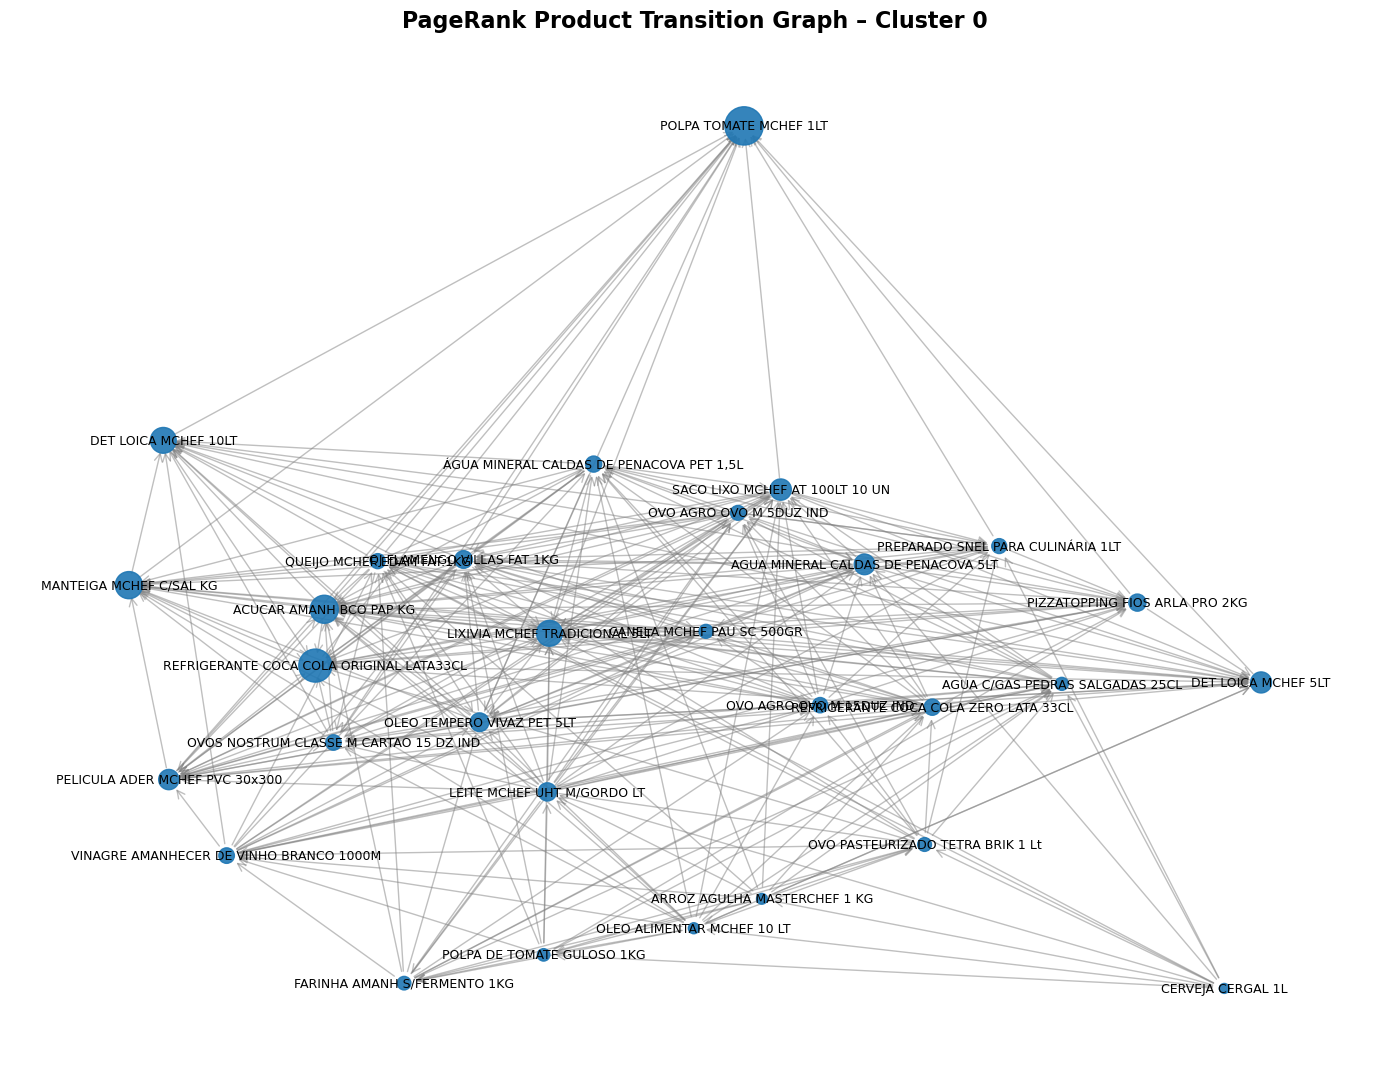

c:\Users\gonca\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


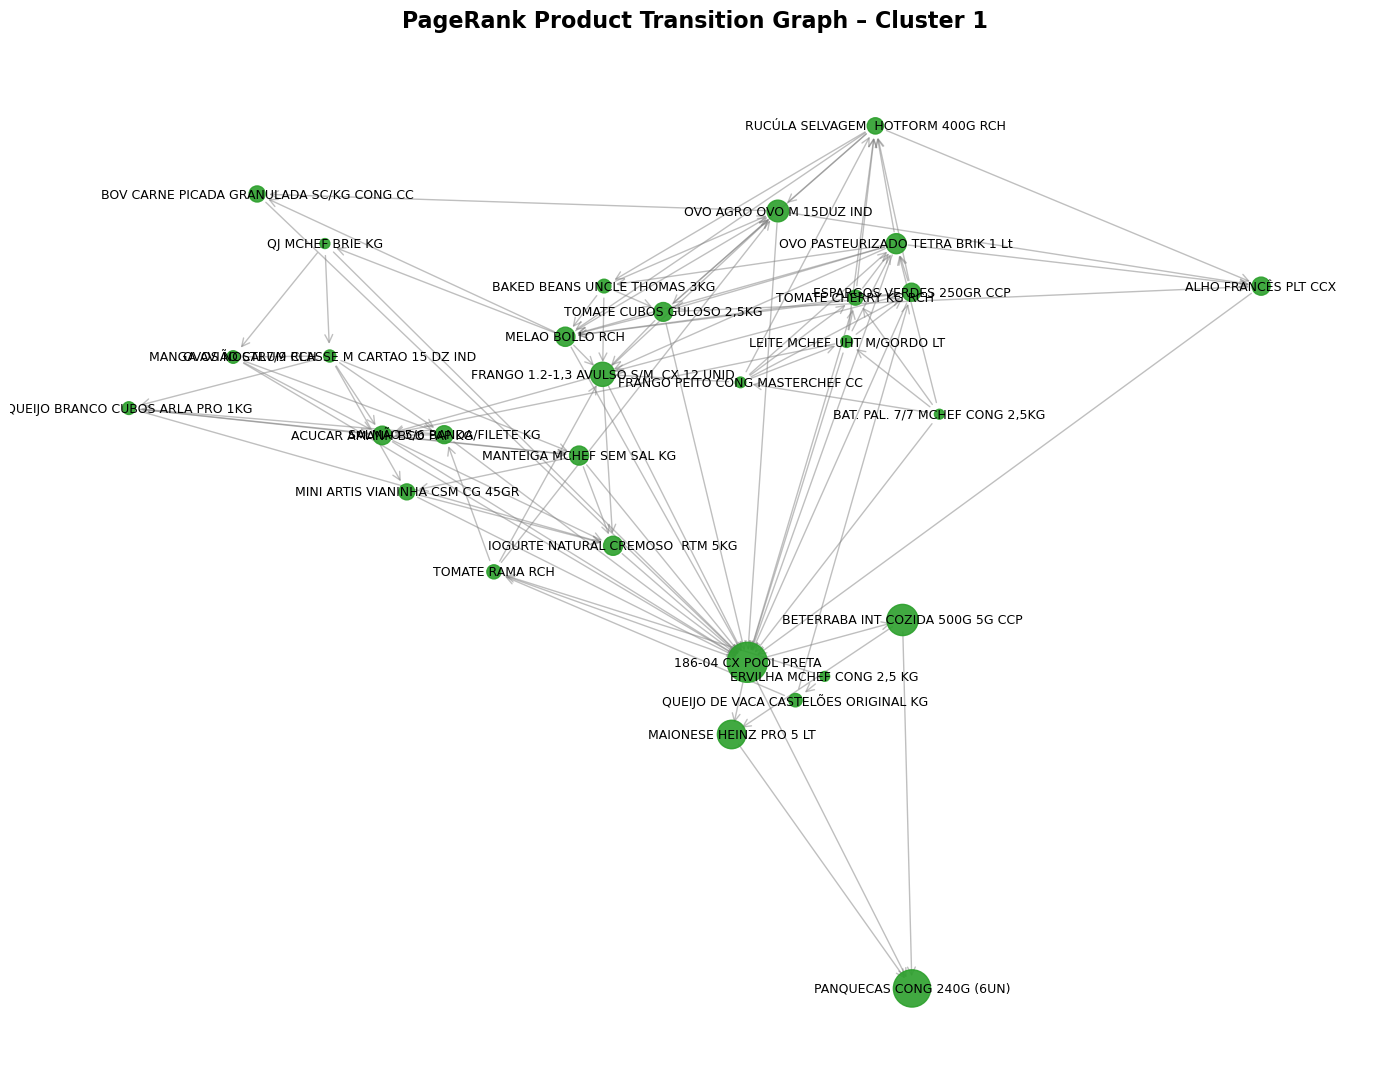

c:\Users\gonca\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


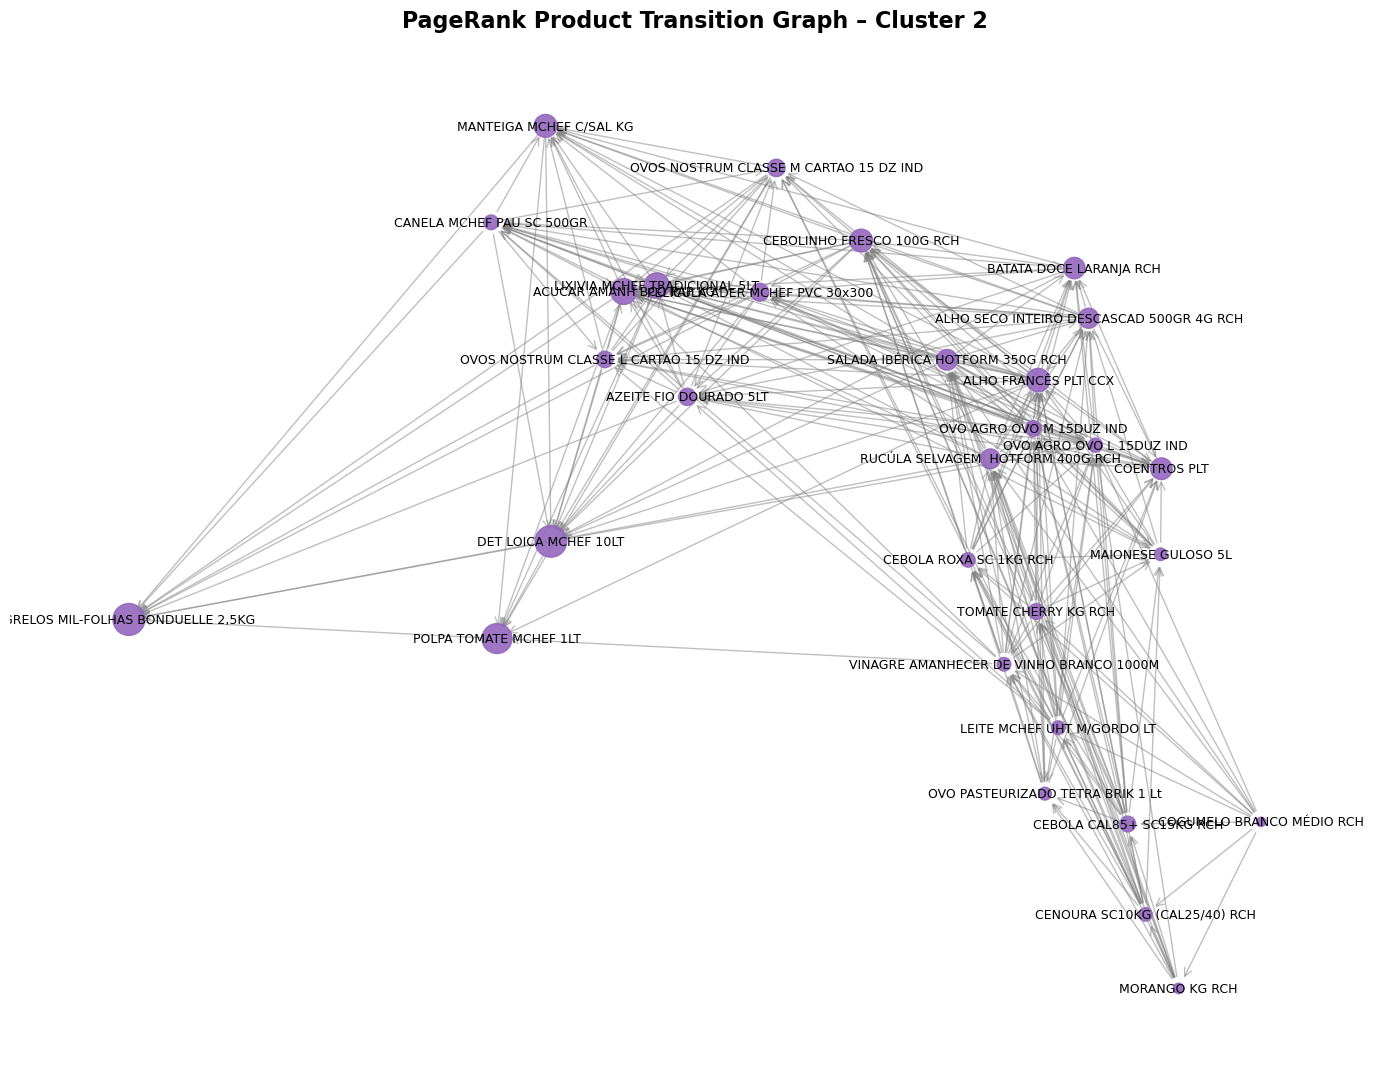

c:\Users\gonca\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


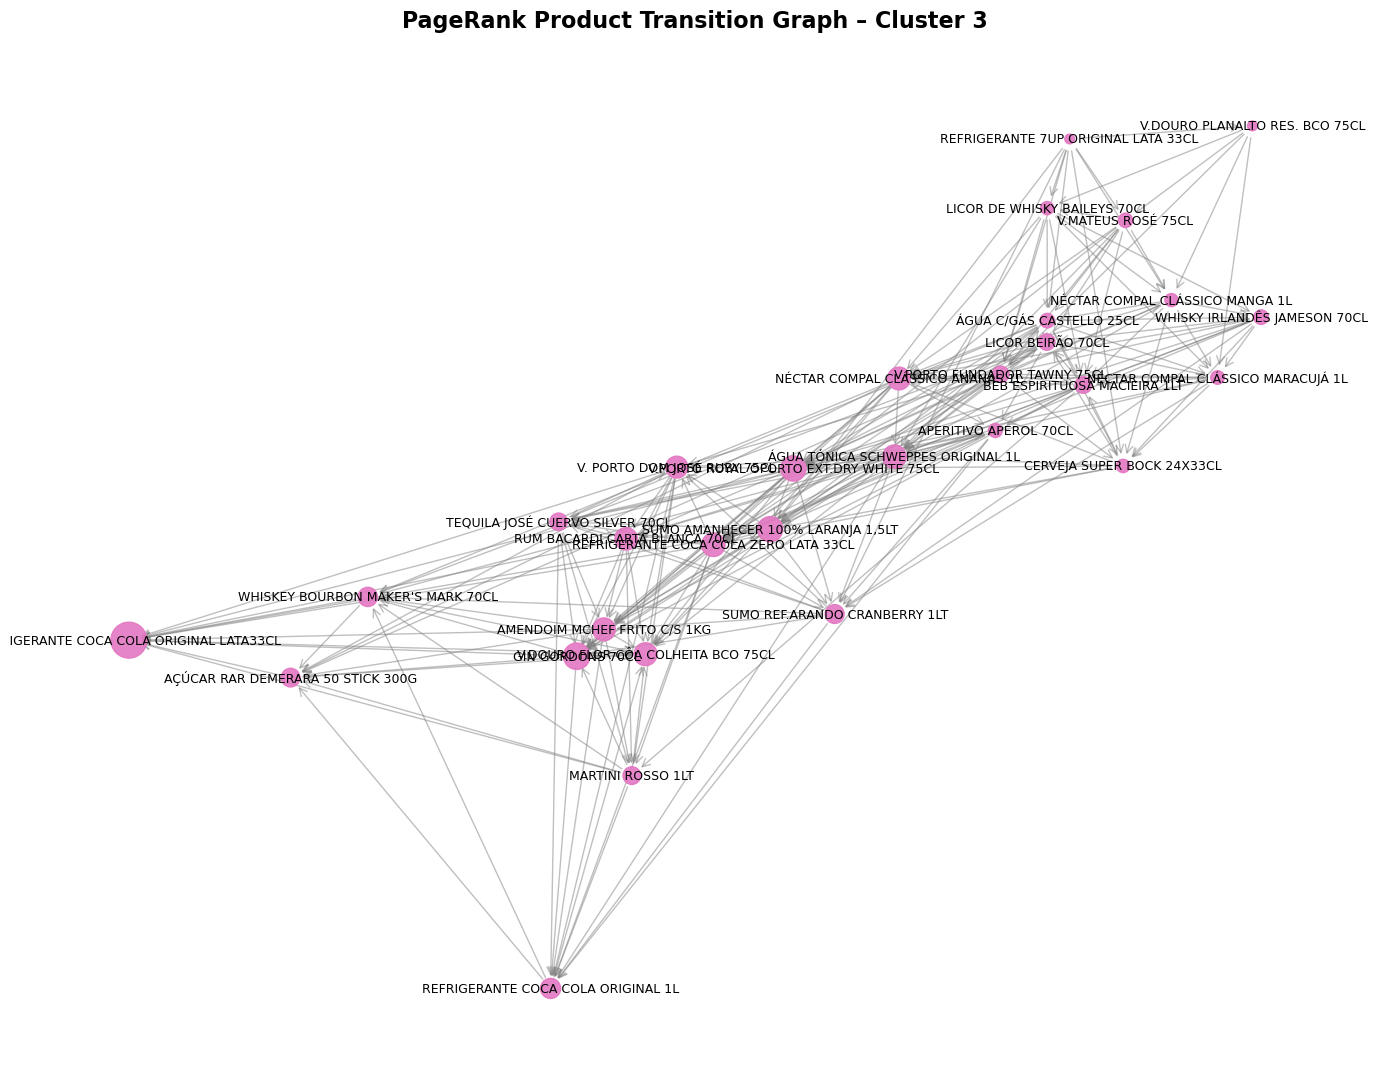

c:\Users\gonca\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


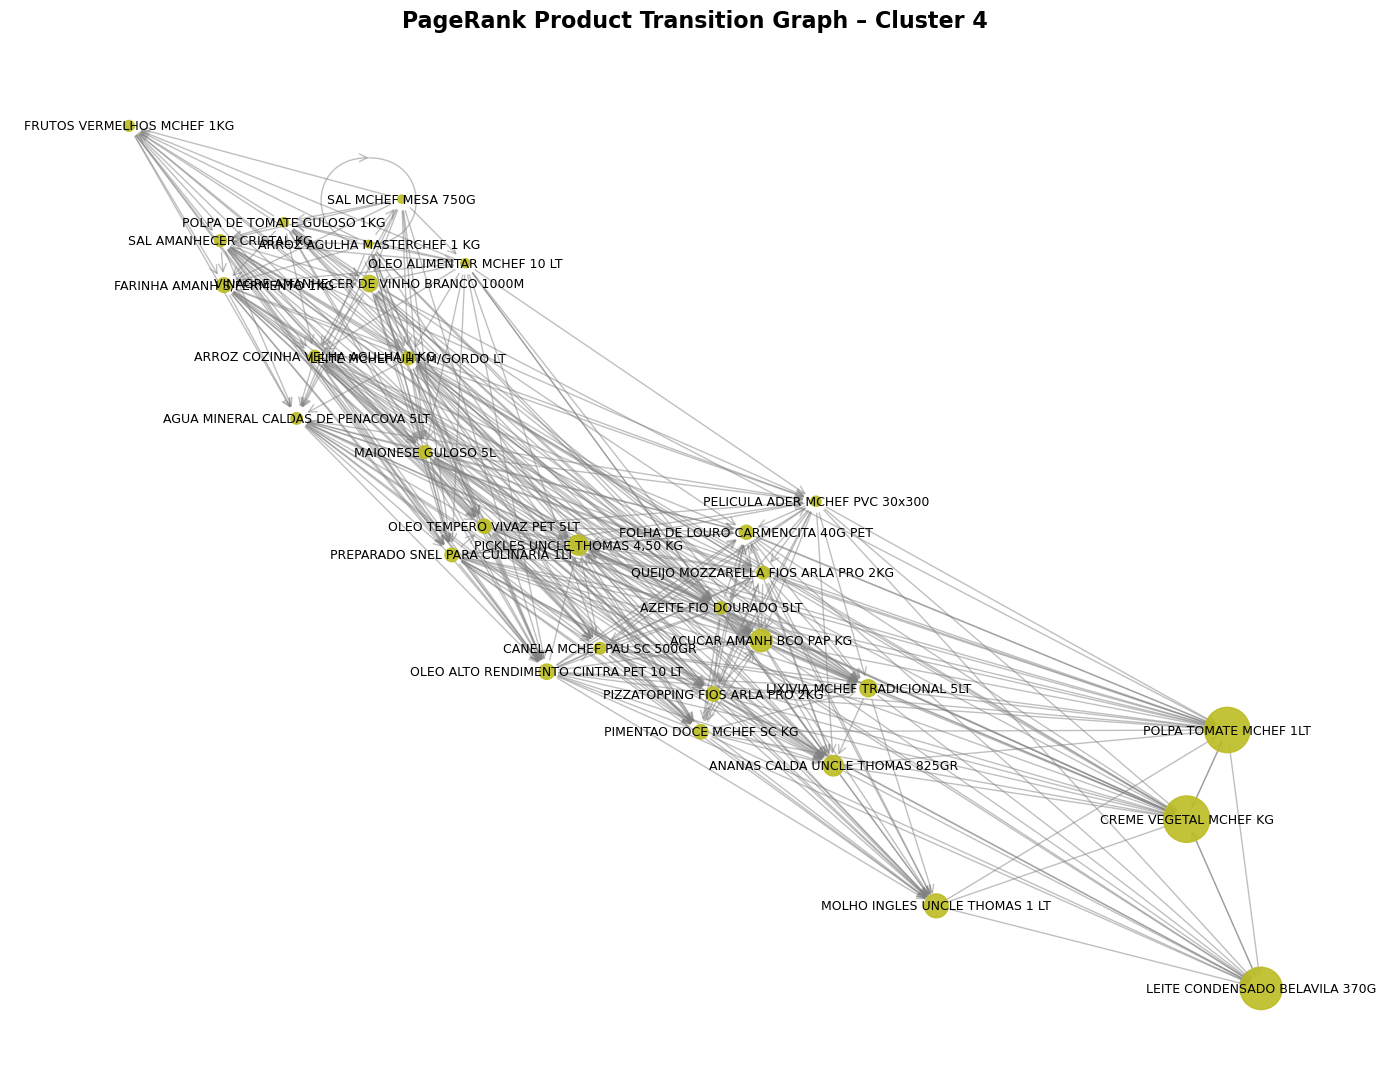

c:\Users\gonca\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


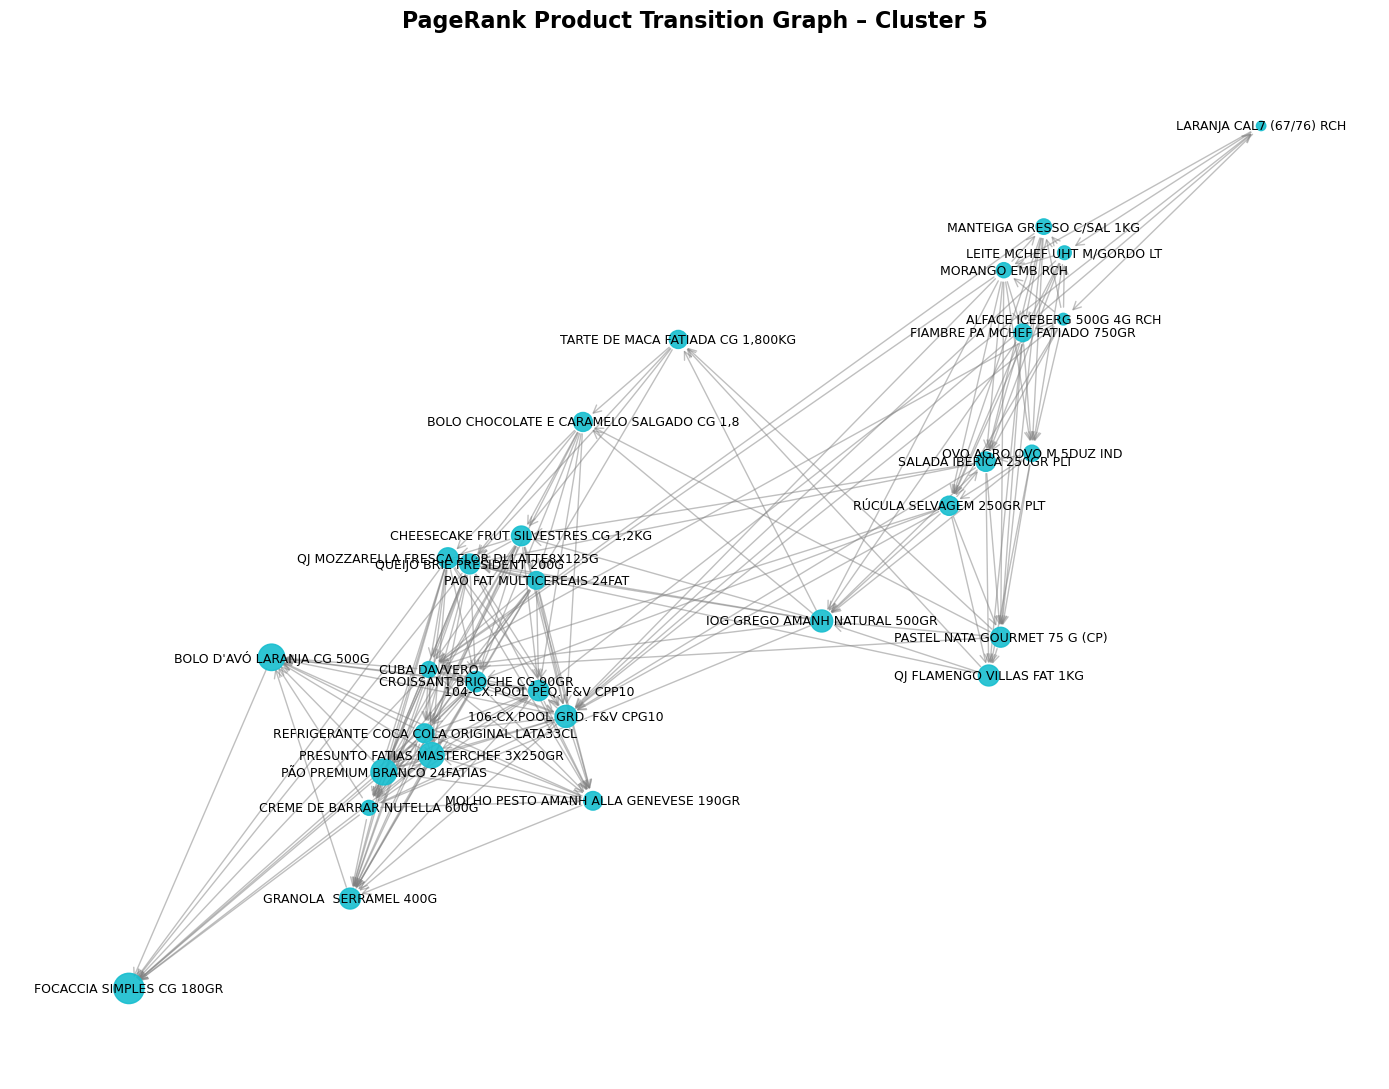

In [24]:
def pagerank_visualizations(data, cluster_col='Cluster', top_n_products=30, layout='spring'):
    cluster_ids = sorted(data[cluster_col].unique())
    cmap = cm.get_cmap('tab10', len(cluster_ids))

    for idx, cluster_id in enumerate(cluster_ids):
        cluster_data = data[data[cluster_col] == cluster_id].copy()
        cluster_data['Date'] = pd.to_datetime(cluster_data['Date'])
        cluster_data.sort_values(by=['Client ID', 'Date'], inplace=True)

        transitions = defaultdict(int)
        for (client_id, date), group in cluster_data.groupby(['Client ID', 'Date']):
            sequence = group['Product Description'].tolist()
            for i in range(len(sequence) - 1):
                transitions[(sequence[i], sequence[i + 1])] += 1

        G = nx.DiGraph()
        for (src, tgt), weight in transitions.items():
            G.add_edge(src, tgt, weight=weight)

        top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:top_n_products]
        top_node_names = {n for n, _ in top_nodes}
        G = G.subgraph(top_node_names).copy()

        if len(G.nodes) == 0:
            print(f"Cluster {cluster_id}: No data to visualize.")
            continue

        pr = nx.pagerank(G, alpha=0.85, weight='weight')
        node_sizes = [6000 * pr[n] for n in G.nodes]
        pos = nx.spring_layout(G, seed=42, k=0.6)

        plt.figure(figsize=(14, 11))
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=cmap(idx), alpha=0.9)
        nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=14, edge_color='gray', alpha=0.5)
        nx.draw_networkx_labels(G, pos, font_size=9)
        plt.title(f"PageRank Product Transition Graph – Cluster {cluster_id}", fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
pagerank_visualizations(data, top_n_products=30)

## **PageRank Transition Graphs – Cluster Summary Table**

| Cluster | Central Products                               | Cluster Theme                       | Observations                                                                 |
|---------|------------------------------------------------|-------------------------------------|------------------------------------------------------------------------------|
| 0       | POLPA TOMATE MCHEF 1LT, cleaning products       | Essentials & Cooking Basics         | Highly connected; strong flow toward staple items and household products.   |
| 1       | BETERRABA INT COZIDA 500G, AZEITO.PRETAS        | Diverse Grocery                     | More dispersed network; higher product variety and smaller local hubs.      |
| 2       | POLPA TOMATE MCHEF 1LT, GRELOS BONDUELLE        | Vegetables & Ingredients            | Dense graph with routine co-purchases of core cooking items.                |
| 3       | Coca-Cola, Vinho do Porto, spirits              | Beverages                           | Clear segmentation around drinks; strong transitions across beverage types. |
| 4       | CREME VEGETAL, LEITE CONDENSADO, POLPA TOMATE   | Culinary Bases                      | Tight connectivity among frequently used ingredients.                       |
| 5       | CROISSANT BRIOCHE, CHEESECAKE, BOLO CHOCOLATE   | Bakery & Desserts                   | Focused on sweets and baked goods; habitual dessert buying patterns.        |

### Highlights
- **POLPA TOMATE MCHEF 1LT** is a key product across multiple clusters.
- Graphs reveal cluster-specific buying themes.
- Node centrality supports smart product recommendations based on purchase flow.

## 5.1. PAGE RANK for HORECA

In [25]:
def pagerank_horeca(data, top_n_products=100, top_n_scores=10):
    print(f"\nTop {top_n_scores} Products by Global PageRank")
    
    data = data.copy()
    data['Date'] = pd.to_datetime(data['Date'])
    data.sort_values(by=['Client ID', 'Date'], inplace=True)
    transitions = defaultdict(int)

    for (client_id, date), group in data.groupby(['Client ID', 'Date']):
        product_sequence = group['Product Description'].tolist()
        for i in range(len(product_sequence) - 1):
            from_item = product_sequence[i]
            to_item = product_sequence[i + 1]
            transitions[(from_item, to_item)] += 1

    G = nx.DiGraph()
    for (src, tgt), weight in transitions.items():
        G.add_edge(src, tgt, weight=weight)

    top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:top_n_products]
    top_node_names = set(n for n, _ in top_nodes)
    G = G.subgraph(top_node_names).copy()
    pagerank = nx.pagerank(G, alpha=0.85, weight='weight')
    pr_series = pd.Series(pagerank).sort_values(ascending=False).head(top_n_scores)

    print(tabulate(pr_series.reset_index().rename(columns={"index": "Product", 0: "Score"}), headers='keys', tablefmt='fancy_grid'))

    return pr_series

In [26]:
pagerank_scores_horeca = pagerank_horeca(horeca, top_n_products=100, top_n_scores=10)


Top 10 Products by Global PageRank
╒════╤════════════════════════════════════╤═══════════╕
│    │ Product                            │     Score │
╞════╪════════════════════════════════════╪═══════════╡
│  0 │ * ARROZ BASMATI INOX               │ 0.04955   │
├────┼────────────────────────────────────┼───────────┤
│  1 │ * CENOURA COZIDA SI                │ 0.0368348 │
├────┼────────────────────────────────────┼───────────┤
│  2 │ * BATATINHA COZIDA SI              │ 0.0297309 │
├────┼────────────────────────────────────┼───────────┤
│  3 │ * PERNAS DE FRANGO COZIDAS SI      │ 0.0295808 │
├────┼────────────────────────────────────┼───────────┤
│  4 │ * ARROZ BRANCO SI                  │ 0.0277795 │
├────┼────────────────────────────────────┼───────────┤
│  5 │ * MEDALHÕES DE PESCADA BRASEADO SI │ 0.0266168 │
├────┼────────────────────────────────────┼───────────┤
│  6 │ * MIX LEG JULIANA SAlTEADO SI      │ 0.0257968 │
├────┼────────────────────────────────────┼───────────┤
│  7 │ * CRE

### **PageRank Analysis – HORECA**

The PageRank algorithm identified the most central products based on transition frequency across all client purchases. The top products are mostly essential and versatile meal components.

- **Top-ranked product** is `* ARROZ BASMATI INOX`, likely due to its consistent inclusion in meals.
- **Vegetable sides** like `* CENOURA COZIDA SI` and `* BATATINHA COZIDA SI` also rank high, reflecting their frequent pairing.
- **Protein staples** such as `* PERNAS DE FRANGO COZIDAS SI` and `* MEDALHÕES DE PESCADA` suggest common main course patterns.
- **Soups and prepped bases** like `* CREME DE CENOURA SS 3LT` and `* MIX LEG JULIANA SAUTEADO SI` highlight demand for ready-to-serve or preparatory items.

# **6. Integrated Recommendation System**

## 6.1. SMART BASKET (Check-In)

In [53]:
def smart_basket(data, pagerank_results, cluster_similarities_dict, top_n=5, similarity_metric='cosine'):
    basket_rows = []

    for cluster_id in sorted(pagerank_results.keys()):
        if cluster_id not in cluster_similarities_dict:
            continue

        pr_top_products = pagerank_results[cluster_id].head(10).index.tolist()
        sim_matrix = cluster_similarities_dict[cluster_id][similarity_metric]
        recommended = set(pr_top_products[:top_n])

        for product in pr_top_products:
            if product not in sim_matrix.index:
                continue
            similar_products = sim_matrix[product].drop(index=product).sort_values(ascending=False)
            for sim_product in similar_products.index:
                if sim_product not in recommended:
                    recommended.add(sim_product)
                if len(recommended) >= top_n:
                    break
            if len(recommended) >= top_n:
                break

        formatted = "\n• " + "\n• ".join(list(recommended)[:top_n])
        basket_rows.append({'Cluster': cluster_id, 'Smart Basket': formatted})

    df = pd.DataFrame(basket_rows)
    return df.style.set_properties(subset=['Smart Basket'], **{'white-space': 'pre-wrap'})

In [54]:
smart_basket = smart_basket(data, pagerank_results, cluster_similarities_dict, top_n=5, similarity_metric='cosine')
display(smart_basket)

,Cluster,Smart Basket
0,0,"• ÁGUA MINERAL CALDAS DE PENACOVA PET 1,5L • FIAMBRE FATIADO CASA PORTUGUESA 750G • CREME VEGETAL MCHEF KG • SACO LIXO AMANHECER FF 50L 15 UN • POLPA TOMATE MCHEF 1LT"
1,1,"• 186-04 CX POOL PRETA • FRANGO INTEIRO QUALIKO IVP CG 1,2KG • BETERRABA INT COZIDA 500G 5G CCP • MORANGO KG RCH • AZEITO.PRETAS S/CAROÇO EXCELENCIA 3KG"
2,2,"• POLPA TOMATE MCHEF 1LT • LEITE CONDENSADO BELAVILA 370G • GRELOS MIL-FOLHAS BONDUELLE 2,5KG • CREME VEGETAL MCHEF KG • BROCULO 40-60 CONG 2,5 KG"
3,3,"• SUMO AMANHECER 100% LARANJA 1,5LT • GINGER ALE SCHWEPPES TP 20CL • REFRIGERANTE COCA COLA ZERO LATA 33CL • REFRIGERANTE COCA COLA ORIGINAL LATA33CL • REFRIGERANTE COCA COLA ZERO 1L"
4,4,"• MILHO DOCE MONTEY LATA 340GR • PAO RALADO MCHEF 1 KG • LEITE CONDENSADO BELAVILA 370G • GRELOS MIL-FOLHAS BONDUELLE 2,5KG • CREME VEGETAL MCHEF KG"
5,5,"• CROISSANT BRIOCHE INVICTA CG 90GR • BOLO CHOCOLATE E CARAMELO SALGADO CG 1,8 • CARACOL DE CANELA EUROPASTRY CG 120GR • FOCACCIA SIMPLES CG 180GR • BOLO D'AVÓ LARANJA CG 500G"


### Smart Basket Interpretation

This table represents the output of the **Smart Basket system per customer cluster**, which combines:
- **PageRank**: to identify the most central and frequently purchased products within each cluster;
- **Similarity Measures** (Cosine): to find complementary or substitutable items often bought together.

Each row corresponds to a **customer cluster**, and the "Smart Basket" column lists the **top 5 product suggestions** for a typical customer in that segment.

---

**Cluster 0:**
- **Products:** Água Mineral, Fiambre Fatiado, Creme Vegetal, Polpa de Tomate, Saco Lixo
- **Insight:** Basic daily-use groceries dominate this cluster, indicating general household or institutional consumption needs.

**Cluster 1:**
- **Products:** Frango Inteiro, Morango, Beterraba, Azeitonas, CX Pool Preta
- **Insight:** Mix of **fresh produce and bulk items**, likely large-scale food prep or health-conscious buyers.

**Cluster 2:**
- **Products:** Polpa de Tomate, Leite Condensado, Grelos Mil-Folhas, Creme Vegetal, Brócolo Congelado
- **Insight:** Base ingredients and frozen vegetables suggest frequent usage in food-service or institutional kitchens.

**Cluster 3:**
- **Products:** Sumo Amanhecer, Coca-Cola Zero, Coca-Cola Original, Ginger Ale
- **Insight:** Strong beverage focus, indicating clients such as cafés, bars, or event providers.

**Cluster 4:**
- **Products:** Milho Doce, Pão Ralado, Leite Condensado, Grelos Mil-Folhas, Creme Vegetal
- **Insight:** Pantry staples and versatile ingredients dominate — ideal for consistent restocking or base meal preparation.

**Cluster 5:**
- **Products:** Croissant Brioche, Focaccia, Cheesecake, Bolo de Laranja, Caracol Canela
- **Insight:** Ready-to-eat bakery and dessert items — fitting for bakeries, cafés or breakfast-oriented vendors.

### 6.1.1. SMART BASKET - HORECA

In [ ]:
def smart_basket_horeca(similarity_dict, pagerank_scores, top_n=5, similar_n=3, similarity_metric='cosine'):
    top_products = pagerank_scores.head(top_n).index.tolist()
    sim_matrix = similarity_dict[similarity_metric]
    rows = []

    for product in top_products:
        if product not in sim_matrix.index:
            continue
        similar_products = sim_matrix[product].drop(index=product).sort_values(ascending=False)
        recommendations = [p for p in similar_products.index if p not in top_products][:similar_n]
        rows.append({'Top 5 Products': product, 'Suggested by Similarity': recommendations})

    return pd.DataFrame(rows)

In [ ]:
smart_basket_horeca_df = smart_basket_horeca(similarity_dict=horeca_similarity, pagerank_scores=pagerank_scores_horeca, top_n=5, similar_n=3,similarity_metric='cosine')
display(smart_basket_horeca_df)

,Top 5 Products,Suggested by Similarity
0,* ARROZ BASMATI INOX,"[* PESCADA À POVEIRA INOX, * BATATINHA ASSADA ..."
1,* CENOURA COZIDA SI,"[* BRÒCULOS COZIDOS SI, * MIX LEG JULIANA SAlT..."
2,* BATATINHA COZIDA SI,"[* BRÒCULOS COZIDOS SI, * PESCADA COZIDA SI, *..."
3,* PERNAS DE FRANGO COZIDAS SI,"[*PERNAS DE FRANGO NO FORNO SI, * ARROZ DE CEN..."
4,* ARROZ BRANCO SI,"[* BRÒCULOS COZIDOS SI, * MIX LEG JULIANA SAlT..."


## 6.2. "DID YOU FORGET?" (Check-Out)

In [ ]:
def checkout_recommendations(current_basket, rules_df, similarities, top_n=2, similarity_metric='dice'):
    recommendations = []

    for product in current_basket:
        recs_for_product = []

        for _, rule in rules_df.iterrows():
            antecedents = set(rule['antecedents'])
            consequents = set(rule['consequents'])

            if product in antecedents and not consequents.issubset(current_basket):
                for item in consequents:
                    if item not in current_basket and item not in recs_for_product:
                        if item in similarities[similarity_metric].columns:
                            similar_items = similarities[similarity_metric][item].drop(index=item).sort_values(ascending=False)
                            similar_filtered = [i for i in similar_items.index if i not in current_basket][:top_n]
                        else:
                            similar_filtered = []

                        recommendations.append({'Basket Product': product,'Recommended Item': item,'Confidence': round(rule['confidence'], 3),'Lift': round(rule['lift'], 2),'Similar popular items': ', '.join(similar_filtered)})
                        recs_for_product.append(item)

                        if len(recs_for_product) >= top_n:
                            break
            if len(recs_for_product) >= top_n:
                break

    return pd.DataFrame(recommendations)

In [32]:
available_clusters = list(mba_clusters.keys())
random_cluster = random.choice(available_clusters)
rules_df = mba_clusters[random_cluster]
similarities = cluster_similarities_dict[random_cluster]
all_products = list(set(item for rule in rules_df.itertuples() for item in rule.antecedents.union(rule.consequents)))
current_basket = set(random.sample(all_products, k=min(5, len(all_products))))

checkout_df = checkout_recommendations(current_basket, rules_df, similarities, top_n=2, similarity_metric='cosine')

print(f"Randomly selected Cluster: {random_cluster}")
print("Current Basket:", current_basket)
display(checkout_df)

Randomly selected Cluster: 4
Current Basket: {'MOSTARDA HEINZ SAQUETAS 200X10ML', 'CALDO GALINHA KNORR FCO96C KG', 'LEITE CONDENSADO COZIDO BELAVILA 397G', 'POLPA DE MANGA JUS 860G', 'QUEIJO MOZZARELLA FIOS ARLA PRO 2KG'}


,Basket Product,Recommended Item,Confidence,Lift,Similar popular items
0,MOSTARDA HEINZ SAQUETAS 200X10ML,MAIONESE HEINZ SAQ 200X10ML,0.660,16.17,
1,MOSTARDA HEINZ SAQUETAS 200X10ML,KETCHUP HEINZ SAQUETAS 200X10ML,0.743,15.56,
2,CALDO GALINHA KNORR FCO96C KG,ACUCAR AMANH BCO PAP KG,0.550,2.21,"LEITE MCHEF UHT M/GORDO LT, FARINHA AMANH S/FE..."
3,LEITE CONDENSADO COZIDO BELAVILA 397G,FARINHA AMANH S/FERMENTO 1KG,0.395,3.34,"LEITE MCHEF UHT M/GORDO LT, ACUCAR AMANH BCO P..."
4,LEITE CONDENSADO COZIDO BELAVILA 397G,ACUCAR AMANH BCO PAP KG,0.417,1.68,"LEITE MCHEF UHT M/GORDO LT, FARINHA AMANH S/FE..."
5,POLPA DE MANGA JUS 860G,FOLHA DE LOURO CARMENCITA 40G PET,0.382,6.75,
6,POLPA DE MANGA JUS 860G,OLEO TEMPERO VIVAZ PET 5LT,0.477,5.73,"PAO RALADO MCHEF 1 KG, FARINHA AMANH S/FERMENT..."
7,QUEIJO MOZZARELLA FIOS ARLA PRO 2KG,PIZZATOPPING FIOS ARLA PRO 2KG,0.288,4.96,
8,QUEIJO MOZZARELLA FIOS ARLA PRO 2KG,PREPARADO SNEL PARA CULINÁRIA 1LT,0.246,2.68,"MAIONESE GULOSO 5L, PAO RALADO MCHEF 1 KG"


### 6.2.1. "DID YOU FORGET?" - HORECA

In [33]:
def checkout_recommendations_horeca(current_basket, rules_df, similarities, top_n=2, similarity_metric='dice'):
    recommendations = []

    for product in current_basket:
        recs_for_product = []

        for _, rule in rules_df.iterrows():
            antecedents = set(rule['antecedents'])
            consequents = set(rule['consequents'])

            if product in antecedents and not consequents.issubset(current_basket):
                for item in consequents:
                    if item not in current_basket and item not in recs_for_product:
                        if item in similarities[similarity_metric].columns:
                            similar_items = similarities[similarity_metric][item].drop(index=item).sort_values(ascending=False)
                            similar_filtered = [i for i in similar_items.index if i not in current_basket][:top_n]
                        else:
                            similar_filtered = []

                        recommendations.append({'Basket Product': product, 'Recommended Item': item, 'Confidence': round(rule['confidence'], 3), 'Lift': round(rule['lift'], 2), 'Similar popular items': ', '.join(similar_filtered)})
                        recs_for_product.append(item)

                        if len(recs_for_product) >= top_n:
                            break
            if len(recs_for_product) >= top_n:
                break

    return pd.DataFrame(recommendations)

In [34]:
all_products_horeca = list(set(item for rule in horeca_rules.itertuples() for item in rule.antecedents.union(rule.consequents)))
current_basket_horeca = set(random.sample(all_products_horeca, k=min(5, len(all_products_horeca))))

checkout_df_horeca = checkout_recommendations_horeca(current_basket=current_basket_horeca, rules_df=horeca_rules, similarities=horeca_similarity, top_n=2, similarity_metric='cosine')

print("Current HoReCa Basket:", current_basket_horeca)
display(checkout_df_horeca)

Current HoReCa Basket: {'* ARROZ BASMATI', '* LOMBO DE PORCO SI', '* PESCADA COZIDA SI', '* LEG CAMPESTRES SI', '* LEGUMES À BRÀS SI'}


,Basket Product,Recommended Item,Confidence,Lift,Similar popular items
0,* ARROZ BASMATI,* LEGUMES GRELHADOS,0.500,9.09,"* PEITO DE FRANGO GRELHADO, * CARIL GRÃO C LEG..."
1,* LOMBO DE PORCO SI,* TORTILHA DE VEGETAIS SI,0.631,30.08,"* PURE DE BATATA SI, * BACALHAU C/NATAS SI"
2,* LOMBO DE PORCO SI,* EMPADÃO SALMÃO SI,0.400,20.44,"* RATATOUILLE DE LEGUMES SI, * BOLONHESA SI"
3,* PESCADA COZIDA SI,* CARNE DE NOVILHO ESTUFADA SI,0.378,15.30,"* BACALHAU À GOMES DE SÀ SI, * PESCADA À POVEI..."
4,* PESCADA COZIDA SI,* PESCADA À BRÁS SI,0.267,15.06,"* FEIJOADA DE SOJA SI, * ESPARGUETE COZIDO SI"
5,* LEG CAMPESTRES SI,* PESCADA DOURADA SI,0.333,17.88,"* ARROZ DE TOMATE SI, * MEDALHÕES DE PESCADA C..."
6,* LEG CAMPESTRES SI,* FEIJOADA DE SOJA SI,0.342,17.07,"* MEDALHÕES DE PESCADA COM LEGUMES SI, * PERNA..."
7,* LEGUMES À BRÀS SI,* BACALHAU À GOMES DE SÀ SI,0.655,28.67,"* CARNE DE NOVILHO ESTUFADA SI, * ESPARGUETE C..."
8,* LEGUMES À BRÀS SI,* FEIJOADA À TRANSMONTANA SI,0.473,27.42,"* CARNE DE PORCO SALTEADA SI, * ARROZ DE PATO SI"


# **7. Monte Carlo Cross Validation**

In [ ]:
def monte_carlo_cross_validation(data, cluster_id, mba_clusters, cluster_similarities_dict, pagerank_results, cutoff='2022-10-01', max_top_n=10, similarity_metric='cosine'):
    data = data.copy()
    data['Date'] = pd.to_datetime(data['Date'])
    cluster_data = data[data['Cluster'] == cluster_id]
    all_clients = cluster_data['Client ID'].unique()
    rules_df = mba_clusters.get(cluster_id)
    similarities = cluster_similarities_dict.get(cluster_id)
    pagerank_top = pagerank_results.get(cluster_id)

    if rules_df is None or similarities is None or pagerank_top is None:
        raise ValueError(f"Missing data for cluster {cluster_id}.")

    hit_counts, precision_scores, recall_scores = [], [], []
    skipped_clients = 0
    total_evaluated = 0
    detailed_results = []

    for client_id in all_clients:
        client_data = cluster_data[cluster_data['Client ID'] == client_id]
        obs_data = client_data[client_data['Date'] < cutoff]
        test_data = client_data[client_data['Date'] >= cutoff]

        if obs_data.empty or test_data.empty:
            skipped_clients += 1
            continue

        obs_basket = obs_data.groupby('Date')['Product Description'].apply(list)
        future_basket = test_data.groupby('Date')['Product Description'].apply(list)

        if obs_basket.empty or future_basket.empty:
            skipped_clients += 1
            continue

        current_basket = set(random.choice(obs_basket.values))
        held_out = set(random.choice(future_basket.values))
        valid_products = set(cluster_data['Product Description'].unique())
        current_basket = current_basket.intersection(valid_products)
        held_out = held_out.intersection(valid_products)

        if not current_basket or not held_out:
            skipped_clients += 1
            continue

        top_n = min(max_top_n, len(held_out)) if len(held_out) > 0 else max_top_n
        filtered_rules = rules_df[rules_df['confidence'] >= 0.3] if 'confidence' in rules_df.columns else rules_df
        recommendations = checkout_recommendations( current_basket, filtered_rules, similarities, top_n=top_n, similarity_metric=similarity_metric)

        if recommendations.empty:
            fallback_recs = [item for item in pagerank_top.index if item not in current_basket][:top_n]
            recommendations = pd.DataFrame({'Recommended Item': fallback_recs})

        if recommendations.empty or 'Recommended Item' not in recommendations.columns:
            skipped_clients += 1
            continue

        total_evaluated += 1
        recommended_items = set(recommendations['Recommended Item'])
        hits = held_out.intersection(recommended_items)
        precision = len(hits) / top_n
        recall = len(hits) / len(held_out)
        hit = len(hits) > 0
        hit_counts.append(hit)
        precision_scores.append(precision)
        recall_scores.append(recall)

        detailed_results.append({
            'Client ID': client_id,
            'Hit': 'Yes' if hit else 'No',
            'Precision': round(precision, 4),
            'Recall': round(recall, 4),
            'Hits': list(hits),
            'Basket Size': len(current_basket),
            'Held-out Size': len(held_out)})

    results_df = pd.DataFrame(detailed_results)
    summary = {
        'Cluster': cluster_id,
        'Total Clients': len(all_clients),
        'Evaluated Clients': total_evaluated,
        'Skipped Clients': skipped_clients,
        'Success Rate': f"{(sum(hit_counts) / total_evaluated) * 100:.2f}%" if total_evaluated else "N/A",
        'Avg Precision': f"{(sum(precision_scores) / total_evaluated) * 100:.2f}%" if total_evaluated else "N/A",
        'Avg Recall': f"{(sum(recall_scores) / total_evaluated) * 100:.2f}%" if total_evaluated else "N/A",}

    return results_df, summary

In [ ]:
cluster_id = 5
results_df, summary = monte_carlo_cross_validation(
    data=data,
    cluster_id=cluster_id,
    mba_clusters=mba_clusters,
    cluster_similarities_dict=cluster_similarities_dict,
    pagerank_results=pagerank_results,
    cutoff='2022-12-01',
    max_top_n=20,
    similarity_metric='cosine')

print(summary)
display(results_df)

{'Cluster': 5, 'Total Clients': 19, 'Evaluated Clients': 15, 'Skipped Clients': 4, 'Success Rate': '53.33%', 'Avg Precision': '28.71%', 'Avg Recall': '16.93%'}


,Client ID,Hit,Precision,Recall,Hits,Basket Size,Held-out Size
0,210101868,No,0.0000,0.0000,[],41,1
1,210102058,Yes,0.8500,0.4595,"[MORANGO EMB RCH, BANANA IMPORTADA CAT I CÔR 3...",20,37
2,210105769,No,0.0000,0.0000,[],42,1
3,210105969,Yes,0.3571,0.3571,"[* ARROZ DE CENOURA SI, * CARNE DE PORCO SALTE...",27,14
4,210101588,Yes,1.0500,0.5122,"[SALADA GOURMET 175G 4G MCHEF RCH, QJ FLAMENGO...",29,41
5,210101867,Yes,0.4500,0.2727,"[ATUM POSTA OLEO VEGETAL MC 385GR, FIAMBRE PA ...",47,33
6,210103577,Yes,0.6000,0.2553,"[TARTE DE MACA FATIADA CG 1,800KG, MORANGO EMB...",41,47
7,210103706,No,0.0000,0.0000,[],23,1
8,210103969,Yes,0.2500,0.2273,"[REFRIGERANTE COCA COLA ORIGINAL LATA33CL, COU...",21,22
9,210101946,Yes,0.5500,0.2558,"[MORANGO EMB RCH, CHEESECAKE FRUT SILVESTRES C...",46,43


## **Monte Carlo Cross-Validation – Evaluation Summary**

### Metrics Interpretation

| Metric              | Interpretation                                                                 |
|---------------------|---------------------------------------------------------------------------------|
| Total Clients        | Total number of clients in the selected cluster                                |
| Evaluated Clients    | Clients used for evaluation (with valid past and future baskets)               |
| Skipped Clients      | Clients skipped due to insufficient data                                       |
| Success Rate (Hit%)  | Percentage of evaluated clients with at least one correct recommendation       |
| Average Precision    | Percentage of recommended items that were actually bought                      |
| Average Recall       | Percentage of the held-out basket covered by recommendations                   |

---

### Table

| Column          | Meaning                                                                  |
| --------------- | ------------------------------------------------------------------------ |
| `Client ID`     | Unique identifier of the evaluated client.                               |
| `Hit`           | Indicates if **at least one** recommendation matched the future basket.  |
| `Precision`     | Proportion of recommended items that were actually bought.               |
| `Recall`        | Proportion of the actual basket that was covered by the recommendations. |
| `Hits`          | List of correctly recommended items.                                     |
| `Basket Size`   | Number of items in the **input basket** (used to generate recs).         |
| `Held-out Size` | Number of items in the **future basket** (used to evaluate recs).        |

### Analysis

- The system provides relevant recommendations when client purchase patterns are consistent.
- Higher precision indicates that the recommendations are generally accurate and well-targeted.
- Lower recall suggests that some items in the actual future basket were not captured by the recommendation logic.
- Clients with very small or very large baskets can significantly influence average scores.

## 7.1. Monte Carlo Cross Validation - HORECA

In [59]:
def monte_carlo_cross_validation_horeca(data, rules_df, similarities, cutoff='2022-12-01', top_n=10, similarity_metric='cosine'):
    top_clients = data['Client ID'].value_counts().head(20).index.tolist()
    hit_counts = []
    precision_scores = []
    recall_scores = []
    detailed_results = []

    for client_id in top_clients:
        client_data = data[data['Client ID'] == client_id].copy()
        client_data['Date'] = pd.to_datetime(client_data['Date'])
        obs_data = client_data[client_data['Date'] < cutoff]
        test_data = client_data[client_data['Date'] >= cutoff]

        if obs_data.empty or test_data.empty:
            continue

        obs_basket = obs_data.groupby('Date')['Product Description'].apply(list)
        if obs_basket.empty:
            continue
        obs_basket = obs_basket.sample(1).values[0]

        future_basket = test_data.groupby('Date')['Product Description'].apply(list)
        if future_basket.empty:
            continue
        future_basket = future_basket.sample(1).values[0]

        if len(future_basket) < 2:
            continue

        held_out = set(future_basket)
        current_basket = set(obs_basket)
        recs = checkout_recommendations(current_basket, rules_df, similarities, top_n=top_n, similarity_metric=similarity_metric)
        recs = recs.head(top_n)

        if recs.empty or 'Recommended Item' not in recs.columns:
            continue

        recommended_items = set(recs['Recommended Item'])
        hits = held_out.intersection(recommended_items)
        precision = len(hits) / top_n
        recall = len(hits) / len(held_out)
        hit = len(hits) > 0
        hit_counts.append(hit)
        precision_scores.append(precision)
        recall_scores.append(recall)

        detailed_results.append({
            'Client ID': client_id,
            'Hit': 'Yes' if hit else 'No',
            'Precision': round(precision, 4),
            'Recall': round(recall, 4),
            'Hits': list(hits),
            'Basket Size': len(current_basket),
            'Held-out Size': len(held_out)})

    results_df = pd.DataFrame(detailed_results)
    summary = {}

    if not results_df.empty:
        summary = {
            'Evaluated Clients': len(results_df),
            'Skipped Clients': len(top_clients) - len(results_df),
            'Success Rate': f"{(sum(hit_counts) / len(results_df)) * 100:.2f}%" if results_df.shape[0] else "N/A",
            'Avg Precision': f"{(sum(precision_scores) / len(results_df)) * 100:.2f}%" if results_df.shape[0] else "N/A",
            'Avg Recall': f"{(sum(recall_scores) / len(results_df)) * 100:.2f}%" if results_df.shape[0] else "N/A"}
        print(summary)
        display(results_df)
    else:
        print("Not enough data to evaluate.")

    return results_df, summary

In [62]:
results_df, summary = monte_carlo_cross_validation_horeca(
    data=horeca,
    rules_df=horeca_rules,
    similarities=horeca_similarity,
    cutoff='2022-12-01',
    top_n=10,
    similarity_metric='cosine')

{'Evaluated Clients': 4, 'Skipped Clients': 16, 'Success Rate': '50.00%', 'Avg Precision': '20.00%', 'Avg Recall': '9.40%'}


,Client ID,Hit,Precision,Recall,Hits,Basket Size,Held-out Size
0,210105969,Yes,0.7,0.2333,"[*PERNAS DE FRANGO NO FORNO SI, * MEDALHÕES DE...",10,30
1,210105696,No,0.0,0.0000,[],4,2
2,210100182,Yes,0.1,0.1429,[* BATATINHA ASSADA INOX],9,7
3,210103706,No,0.0,0.0000,[],2,3
